# My DUSTED (ish) Pipeline
You have to start by defining the dataset info. 
Currently it only works with librispeech (oops)
1. Loading in the Dataset

In [20]:
from pathlib import Path

name = "librispeech-dev-clean"
in_dir = Path("data/dev-clean")
align_dir = Path("data/alignments/dev-clean")
feat_dir = Path("features")
audio_ext = ".flac" 

In [21]:
from encode import sample_files
from utils.features import DataSet

dataset = DataSet(
    name, in_dir, align_dir, feat_dir, audio_ext 
)

# Choose how many files you want to sample. (-1 = all)
sample_size = 100
sampled_paths = sample_files(dataset, sample_size)
print(len(sampled_paths))

100


In [3]:
# If you want to be fun, check the ladys:
sampled_paths = [
    Path("data/dev-clean/174/50561/174-50561-0005.flac"), 
    Path("data/dev-clean/3081/166546/3081-166546-0058.flac"), 
    Path("data/dev-clean/84/121550/84-121550-0026.flac"),
    Path("data/dev-clean/174/50561/174-50561-0008.flac")
]

In [22]:
from distance import load_units
from joblib import Parallel, delayed

# If the units are already computed and saved in the feat_dir you can simply load them in: 
results = Parallel(n_jobs=2)([
    delayed(load_units)(dataset, sampled_paths, 0.2)  
])
hubert_words, dusted_words = results[0]

Loading Units: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


In [60]:
from encode import get_units
from joblib import Parallel, delayed

# Otherwise you have to first encode the waveforms to get the units.
# Encoding is done using Benji's hubert and kmeans models.
results = Parallel(n_jobs=2)([
    delayed(get_units)(dataset, sampled_paths, 0.2)  
])
hubert_words, dusted_words = results[0]

Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Getting units: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


The next is a little sanity check for the number of word types and their occurences in our sampled data. 
The true words are also stored in an array for later understanding and visualisation.

In [23]:
from collections import Counter
import pandas as pd
import ace_tools_open as tools

num_words = len(hubert_words)
true_words = []

for w in range(num_words): 

    if not isinstance(hubert_words[w].true_word, str):
        true_words.append("_")
    else:
        true_words.append(hubert_words[w].true_word)
        

counts = Counter(true_words)

word_counts_df = pd.DataFrame(counts.items(), columns=["Word", "Count"])
word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)
tools.display_dataframe_to_user(name="Sorted Word Counts", dataframe=word_counts_df)

Sorted Word Counts


2. Calculating the distances between words

In [24]:
from distance import calculate_distance

# Need to specify where the dist matrices are stored -> could maybe look at a different naming convention
out_dir_dusted = Path(f"output/dusted/{sample_size}")
out_dir_hubert = Path(f"output/hubert/{sample_size}")

# If calculate_distance is called with only the words, it does not save the matrices
dist_mat_dusted = calculate_distance(dusted_words, out_dir_dusted)
print()
dist_mat_hubert = calculate_distance(hubert_words, out_dir_hubert)

Calculating Distances: 100%|██████████| 2401/2401 [00:05<00:00, 447.41it/s] 


[[0.         1.         1.         0.66666667 1.        ]
 [1.         0.         1.         1.         0.85714286]
 [1.         1.         0.         1.         1.        ]
 [0.66666667 1.         1.         0.         1.        ]
 [1.         0.85714286 1.         1.         0.        ]]



Calculating Distances: 100%|██████████| 2401/2401 [00:08<00:00, 284.51it/s] 

[[0.         1.         1.         0.75       1.        ]
 [1.         0.         1.         0.95454545 0.81818182]
 [1.         1.         0.         1.         1.        ]
 [0.75       0.95454545 1.         0.         0.90909091]
 [1.         0.81818182 1.         0.90909091 0.        ]]


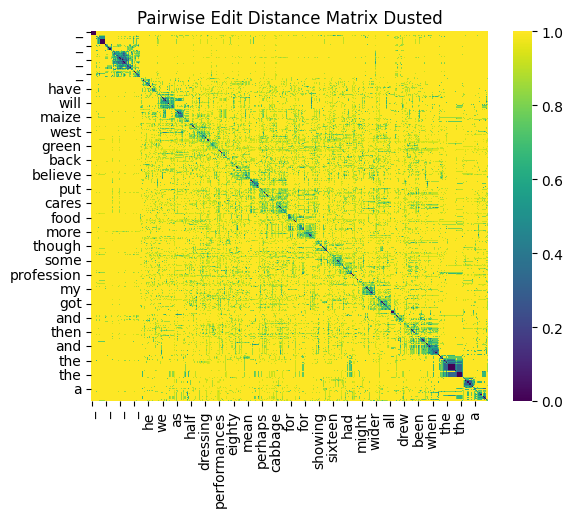

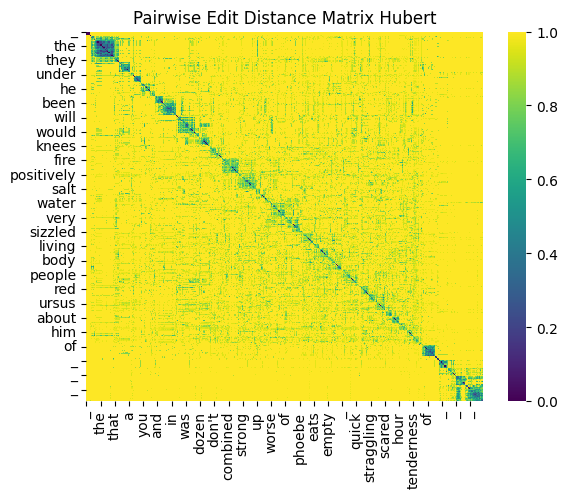

In [25]:
from eval import pairwise_edit_dist_mat

# Visualise the distances
pairwise_edit_dist_mat(dist_mat_dusted, "Pairwise Edit Distance Matrix Dusted", true_words)
pairwise_edit_dist_mat(dist_mat_hubert, "Pairwise Edit Distance Matrix Hubert", true_words)

In [26]:
from cluster import cluster, get_word_clusters

# Get the int_clusters for each of the matrices
dust_clusters = cluster(dist_mat_dusted, 0.3)
hub_clusters = cluster(dist_mat_hubert, 0.3)

# Convert these to word clusters
dust_word_clusters = get_word_clusters(dust_clusters, dusted_words)
hub_word_clusters = get_word_clusters(hub_clusters, hubert_words)

In [27]:
from eval import ned

# Compute the ned for my dusted and hubert clusters - atm my NED is computed only using clusters with > 1 words
ned_dusted = ned(dust_word_clusters, print_inpure=False)
ned_hubert = ned(hub_word_clusters, print_inpure=False)

print(f"DUSTED NED: {ned_dusted}")
print(f"HuBERT NED: {ned_hubert}")

DUSTED NED: 0.33088345582720863
HuBERT NED: 0.08926543802952223


In [28]:
from cluster import get_best_clusters

ned_dusted, duplicate_count_dusted, dust_word_clusters = get_best_clusters(dust_word_clusters, ned_dusted)
print()
ned_hubert, duplicate_counts_hubert, hub_word_clusters = get_best_clusters(hub_word_clusters, ned_hubert)

Iteration 0: NED: 0.330883
Iteration 1: NED: 0.264682
Iteration 2: NED: 0.243279
Iteration 3: NED: 0.252306
Iteration 4: NED: 0.250920
Iteration 5: NED: 0.251669
Iteration 6: NED: 0.230926
Iteration 7: NED: 0.250663
Converged early due to no significant improvement in NED or duplicate count.
Best NED: 0.230926, Best Duplicates: 635

Iteration 0: NED: 0.089265
Iteration 1: NED: 0.082731
Iteration 2: NED: 0.087404
Iteration 3: NED: 0.101043
Converged early due to no significant improvement in NED or duplicate count.
Best NED: 0.087404, Best Duplicates: 886


In [29]:
from eval import words_from_word_units, clusters_purity
            
dust_just_words_clusters = words_from_word_units(dust_word_clusters)
inpurity, total = clusters_purity(dust_just_words_clusters)
print(f"{total} Dusted Clusters with inpurity: {round(inpurity*100, 3)}%")

hub_just_words_clusters = words_from_word_units(hub_word_clusters)
inpurity, total = clusters_purity(hub_just_words_clusters)
print(f"{total} Hubert Clusters with inpurity: {round(inpurity*100, 3)}%")

1529 Dusted Clusters with inpurity: 44.147%
1727 Hubert Clusters with inpurity: 48.176%


In [30]:
from eval import calculate_duplicate_clusters

cluster_counts_dusted, duplicate_counts_dusted = calculate_duplicate_clusters(dust_word_clusters, print_clusters=True)
print()
cluster_counts_hubert, duplicate_counts_hubert = calculate_duplicate_clusters(hub_word_clusters)

Total duplicate clusters (considering word frequency): 635
Duplicate clusters and their counts:
{'_': 6}: 3 times
{'and': 1, 'in': 1}: 5 times
{'_': 3}: 8 times
{'exalted': 1}: 2 times
{'the': 1}: 11 times
{'was': 4}: 2 times
{'us': 1}: 3 times
{'_': 1}: 54 times
{'of': 1}: 23 times
{'encountered': 1}: 2 times
{'that': 1}: 7 times
{'but': 1}: 11 times
{'easily': 1}: 2 times
{'himself': 1}: 3 times
{'is': 1}: 4 times
{'body': 1}: 2 times
{'organ': 1}: 2 times
{'_': 2}: 16 times
{'way': 1}: 2 times
{'box': 1}: 2 times
{'under': 1}: 3 times
{'entered': 1}: 3 times
{'left': 1}: 3 times
{'to': 1}: 5 times
{'maize': 1}: 2 times
{'he': 1}: 6 times
{'and': 1}: 20 times
{'work': 1}: 2 times
{'came': 1}: 2 times
{'_': 4}: 5 times
{'charges': 1}: 3 times
{'only': 1}: 2 times
{'one': 1}: 3 times
{'nest': 1}: 2 times
{'all': 1}: 2 times
{'it': 1}: 19 times
{'food': 1}: 2 times
{'for': 1}: 6 times
{'gave': 1}: 2 times
{'and': 2}: 8 times
{'where': 1}: 3 times
{'with': 1}: 8 times
{'whatever': 1}: 2 

In [32]:
def display_words(word_units):

    num_words = len(word_units)
    true_words = []

    for w in range(num_words): 

        if not isinstance(word_units[w].true_word, str):
            true_words.append("_")
        else:
            true_words.append(word_units[w].true_word)
            

    counts = Counter(true_words)

    word_counts_df = pd.DataFrame(counts.items(), columns=["Word", "Count"])
    word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)
    tools.display_dataframe_to_user(name="Sorted Word Counts", dataframe=word_counts_df)

In [ ]:
from encode import sample_files

query_path = sample_files(dataset, sample_size=1)

from distance import load_units

query_hub_words, query_dusted_words = load_units(dataset, query_path, 0.2)

from cluster import get_distance_to_centroids, get_cluster_centroids

hub_centroids = get_cluster_centroids(hub_word_clusters)
query_hub_words = get_distance_to_centroids([query_hub_words], hub_centroids)

import editdistance

query_distances = []
for word in query_hub_words:
    prediction = hub_centroids[word.cluster_id].true_word
    print(word.true_word, prediction)


Loading Units: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


and and
like like
toned own
bell l
so so
<unk> being
quiet kind
_ _
the the
mute moon
of of
thought not
_ _
now now
all all
_ _
spoon than
was was
it it
her her
duty duty
tea take
to to
woodley which
_ _
be be
a a
a a
deep deep
miss miss
was was
